An example to demonstrate online dynamic mode decomposition

We take a 2D time varying system given by dx/dt = A(t)x
where x = [x1,x2]', A(t) = [0,w(t);-w(t),0], 
w(t)=1+epsilon*t, epsilon=0.1. The slowly time varying eigenvlaues of A(t)
are pure imaginary, +(1+0.1t)j and -(1+0.1t)j, where j is the imaginary unit.

At time step k, define two matrix X(k) = [x(1),x(2),...,x(k)], 
Y(k) = [y(1),y(2),...,y(k)], that contain all the past snapshot pairs, 
we would like to compute Ak = Yk*pinv(Xk). This can be done by brute-force 
batch DMD, and by efficient rank-1 updating online DMD algrithm. Batch DMD 
computes DMD matrix by brute-force taking the pseudo-inverse directly.
Online DMD computes the DMD matrix by using efficient rank-1 update idea.

We compare the performance of online DMD (with weighting=1,0.9) with the 
brute-force batch DMD approach in terms of tracking time varying eigenvalues, 
by comparison with the analytical solution. Online DMD (weighting=1) and 
batch DMD should agree with each other (up to machine round-offer errors).

Authors: 
    Hao Zhang
    Clarence W. Rowley

References:
    Zhang, Hao, Clarence W. Rowley, Eric A. Deem, and Louis N. Cattafesta. "Online dynamic mode decomposition for time-varying systems." SIAM Journal on Applied Dynamical Systems 18, no. 3 (2019): 1586-1609.
            
Date created: April 2017

In [1]:
!pip install -r requirements.txt

In [18]:
import time

import matplotlib.pyplot as plt
import numpy as np
from odmd import OnlineDMD
from scipy.integrate import odeint

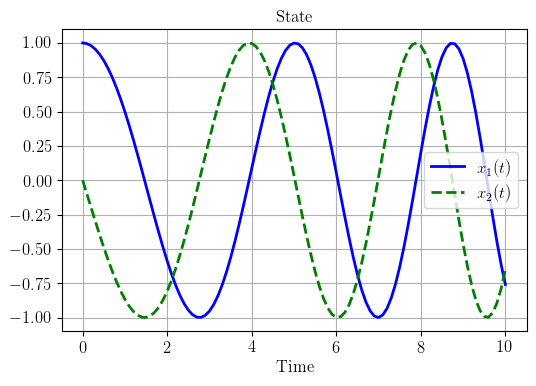

In [38]:
# define dynamics
epsilon = 1e-1
def dyn(x, t):
    x1, x2 = x
    dxdt = [(1+epsilon*t)*x2, -(1+epsilon*t)*x1]
    return dxdt

# integrate from initial condition [1,0]
tspan = np.linspace(0, 10, 101)
dt = 0.1
x0 = [1, 0]
xsol = odeint(dyn, x0, tspan).T
# extract snapshots
x, y = xsol[:, :-1], xsol[:, 1:]
t = tspan[1:]
# true dynamics, true eigenvalues
n, m = len(x[:, 0]), len(x[0, :])
A = np.empty((n, n, m))
evals = np.empty((n, m), dtype=complex)
for k in range(m):
    A[:, :, k] = np.array([[0, (1+epsilon*t[k])], [-(1+epsilon*t[k]), 0]])
    evals[:, k] = np.linalg.eigvals(A[:, :, k])

# visualize snapshots
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(6,4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(tspan, xsol[0, :], 'b-', linewidth=2.0,  label='$x_1(t)$')
plt.plot(tspan, xsol[1, :], 'g--', linewidth=2.0,  label='$x_2(t)$')
plt.legend(loc='best', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('State', fontsize=12)
plt.tick_params(labelsize=12)
plt.grid()
plt.show()

Batch DMD, time = 0.03573012351989746 secs
Online DMD, weighting = 1, time = 0.0201108455657959 secs
Online DMD, weighting = 0.9, time = 0.018149852752685547 secs


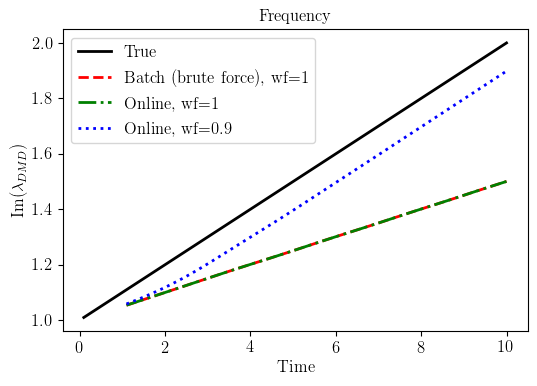

In [39]:
# batch DMD
q = 10
AbatchDMD = np.empty((n, n, m))
evalsbatchDMD = np.empty((n, m), dtype=complex)
start = time.time()
for k in range(q, m):
    AbatchDMD[:, :, k] = y[:, :k+1].dot(np.linalg.pinv(x[:, :k+1]))
    evalsbatchDMD[:, k] = np.log(np.linalg.eigvals(AbatchDMD[:, :, k]))/dt
end = time.time()
print("Batch DMD, time = " + str(end-start) + " secs")


# Online DMD, weighting = 1
evalsonlineDMD1 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 1.0)
odmd.initialize(x[:, :q], y[:, :q])
start = time.time()
for k in range(q, m):
    odmd.update(x[:, k], y[:, k])
    evalsonlineDMD1[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 1, time = " + str(end-start) + " secs")


# Online DMD, weighting = 0.9
evalsonlineDMD2 = np.empty((n, m), dtype=complex)
odmd = OnlineDMD(n, 0.9)
odmd.initialize(x[:, :q], y[:, :q])
start = time.time()
for k in range(q, m):
    odmd.update(x[:, k], y[:, k])
    evalsonlineDMD2[:, k] = np.log(np.linalg.eigvals(odmd.A))/dt
end = time.time()
print("Online DMD, weighting = 0.9, time = " + str(end-start) + " secs")


# visualize true, batch, online (weighting=1,0.9)
plt.rcParams['figure.dpi'] = 100
plt.figure(figsize=(6, 4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title("Frequency", fontsize=12)
plt.plot(t, np.imag(evals[0, :]), 'k-', label='True', linewidth=2.0)
plt.plot(t[q:], np.imag(evalsbatchDMD[0, q:]),
         'r--', label='Batch (brute force), wf=1', linewidth=2.0)
plt.plot(t[q:], np.imag(evalsonlineDMD1[0, q:]),
         'g-.', label='Online, wf=1', linewidth=2.0)
plt.plot(t[q:], np.imag(evalsonlineDMD2[0, q:]), 'b:',
         label='Online, wf=0.9', linewidth=2.0)
plt.tick_params(labelsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Im($\lambda_{DMD}$)', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()